# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from itertools import product as it_product

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

[example notebook: link](https://github.com/gakhov/pycon-ua-2018/blob/master/stochastic-models.ipynb)

# Parameters

In [3]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [4]:
all_data_path = r'../../data/snow_data_clean.pkl'

In [5]:
long_series_df = pd.read_pickle(all_data_path).fillna(0)  # TODO: fix fillna func in data cleaning notebook

def resample_by_month(df, time_col):
    """resample df on monthly basis using specified timestamp column"""
    
    # handling of time_col
    acceptable_time_col = ['timestamp', 'pseudo_ts']
    other_time_col = [x for x in acceptable_time_col if x != time_col].pop()
    if time_col not in acceptable_time_col:
        raise Exception(f'must be in {acceptable_time_col}')
    
    month = (df
             .set_index(f'{time_col}')
             .resample('M')
             .agg({'base': 'mean', 'snowfall': 'sum', 'station': 'first', 
                   'region': 'first', 'state': 'first', 'ski_yr': 'first',
                   f'{other_time_col}': 'first'})
            )
    return month

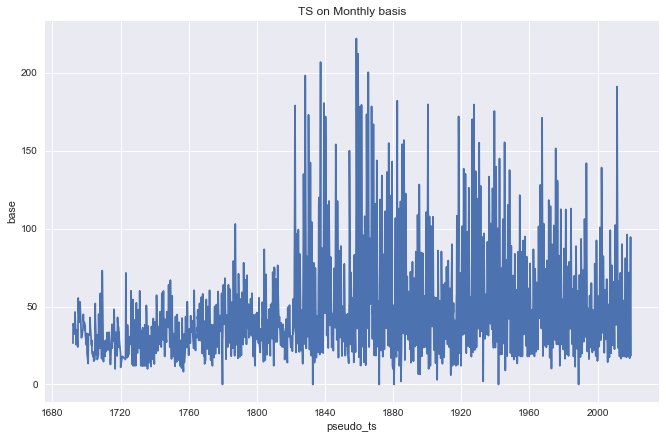

In [6]:
month_ts_df = resample_by_month(long_series_df, 'timestamp')
g = sns.lineplot(data=month_ts_df.reset_index(), x='pseudo_ts', y='base')
g.set_title("TS on Monthly basis");

In [7]:
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .reset_index()
              .query('region=="Colorado"')
              [['base', 'pseudo_ts', 'station']]
              .sort_values(by='pseudo_ts')
             )
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [9]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())

In [10]:
def y_and_yhat_plotter(model=None, endog=None, exog=None, query_filter=None, date_between=None):
    """endog should be df with time series data and pseudo_ts"""
    df = endog.copy()
    df.columns = ['y', 'pseudo_ts']
    yhat = model.fit().predict(df.values, exog)
    df['yhat'] = yhat
    if query_filter:
        df = df.query(query_filter)
    if date_between:
        df = df.loc[df.pseudo_ts.between(*date_between)]
    df = df.melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(data=df, x='pseudo_ts', y='value', hue='variable')
    plt.show();

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

In [43]:
def time_crossval(model, X, y):
    """takes sklearn-API model and returns CV results
    input:
        model: sklearn-API model
        X: 
        Y:
    """
    time_split = TimeSeriesSplit(8)
    cv_results = cross_validate(model, X, y, cv=time_split, 
                            scoring=['neg_root_mean_squared_error', 'r2',
                                     'neg_mean_absolute_error'], n_jobs=1) 
    return cv_results

# TF LSTM models
 

In [ ]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

# invert transform
inverted_X = scaler.inverse_transform(scaled_X)



In [ ]:
def fit_lstm(train, batch_size, n_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Prophet models
GAM timeseries model 